In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation

# Stereo vision, and triangulation

In [2]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def Pi(points):
    n,p = points.shape
    new_points = np.vstack((points, np.ones(p)))
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

def projectpoints(K,R,t,Q):
    homogeneous = Pi(Q)
    P = K @ ( np.hstack((R,t)) )
    q = P @ homogeneous
    q = PiInv(q)
    return q

# Epipolar geometry

In [3]:
K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])

# Cam1
R1 = np.identity(3)
t1 = np.array([[0], [0], [0]])

# Cam2
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([[0.2], [2], [1]])


## Exercise 3.1

In [4]:
Q = np.array([[1], [0.5], [4]])
q1 = projectpoints(K,R1,t1,Q)
q2 = projectpoints(K,R2,t2,Q)

In [5]:
q1, q2

(array([[550.],
        [325.]]),
 array([[582.47256835],
        [185.98985776]]))

## Exercise 3.2

In [6]:
def CrossOp(p):
    M = np.array([[0, -p[2,0], p[1,0]],[p[2,0], 0, -p[0,0]],[-p[1,0], p[0,0], 0]]) 
    return M

## Exercise 3.3

In [7]:
E = CrossOp(t2) @ R2 # essential matrix
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K) # fundamental matrix
F

array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

## Exercise 3.4

In [8]:
l = F @ Pi(q1)
l*4

array([[ 8.95620504e-03],
       [ 3.66751496e-04],
       [-5.28495581e+00]])

## Exercise 3.5

In [9]:
Pi(q2).T @ l

array([[4.4408921e-16]])

Taking numerical precision into account, the point is on the line.


This must be true, since both the point q2 and the line l are derived from the same 3D point Q.
This 3D point yields a single epipolar plane, and the plane yields a single line in each camera. The
projections of the 3D point must lie on the epipolar lines.

## Exercise 3.6

In [10]:
M = np.hstack((R1,t1))
M = np.vstack((M,np.zeros((1,M.shape[1]))))
M[-1,-1] = 1
M

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [11]:
Qtild = M @ Pi(Q)
Qtild

array([[1. ],
       [0.5],
       [4. ],
       [1. ]])

In [12]:
Minv = np.hstack((R1.T,-R1.T @ t1))
Minv = np.vstack((Minv,np.zeros((1,Minv.shape[1]))))
Minv[-1,-1] = 1
Minv

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [13]:
Minv @ Qtild

array([[1. ],
       [0.5],
       [4. ],
       [1. ]])

## Exercise 3.7

See pdf

# Applied epipolar geometry

## Exercise 3.8

In [14]:
data = np.load('TwoImageData.npy', allow_pickle=True).item()
im1 = data['im1']
im1 = im1.astype(float)/255
im2 = data['im2']
im2 = im2.astype(float)/255
R1 = data['R1']
R2 = data['R2']
t1 = data['t1']
t2 = data['t2']
K = data['K']

## Exercise 3.9

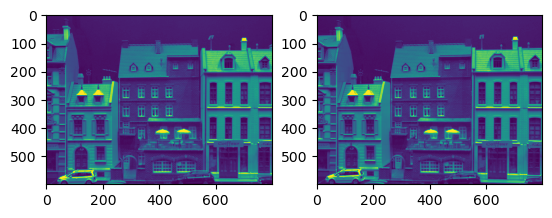

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1)
ax[1].imshow(im2)

In [16]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    plt.plot(*np.array(P).T)

In [17]:
# because cam1 = origin
R = R2
t = t2 

E = CrossOp(t) @ R # essential matrix
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K) # fundamental matrix
F

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [18]:
%matplotlib qt 

fig, ax = plt.subplots(1,2)
ax[0].imshow(im1,'gray')
ax[1].imshow(im2,'gray')

x = plt.ginput(1)
x = np.array(x).T

l = F @ Pi(x)

DrawLine(l, im2.shape)

In [21]:
print(PiInv(l))

[[ 1.20254032e-05]
 [-3.30497867e-03]]


## Exercise 3.10

In [39]:
# because cam1 = origin
R = np.linalg.inv(R2)
t = -t2 

E = CrossOp(t) @ R # essential matrix
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K) # fundamental matrix
F

array([[ 6.66701863e-12,  7.85086207e-10, -1.23759220e-07],
       [-2.54146459e-09, -4.62695184e-12, -3.12850650e-05],
       [ 6.63241245e-07,  3.21733502e-05, -2.70428056e-04]])

In [40]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1,'gray')
ax[1].imshow(im2,'gray')

x = plt.ginput(1)
x = np.array(x).T

l = F @ Pi(x)

DrawLine(l, im1.shape)

# Triangulation

## Exercise 3.11

In [3]:
def triangulate(qs, Ps):
    """
    qs : list of n pixel coordinates (q1, q2,. . . , qn)
    Ps : list of n projection matrices (P1, P2, . . . , Pn)
    return the triangulation of the point in 3D using the linear algorithm.
    """
    n = len(Ps)
    B = np.zeros((2*n,4))
    for i in range(n):
        B[i*2,:] = Ps[i][2,:] * qs[i][0] - Ps[i][0,:]
        B[i*2+1,:] = Ps[i][2,:] * qs[i][1] - Ps[i][1,:]
        
    Q = np.linalg.svd(B)[2][-1,:]
    Q.shape += (1,)
    return PiInv(Q)

In [4]:
## test function

K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])

# Cam1
R1 = np.identity(3)
t1 = np.array([[0], [0], [0]])
P1 = K @ ( np.hstack((R1,t1)) )

# Cam2
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([[0.2], [2], [1]])
P2 = K @ ( np.hstack((R2,t2)) )

Q = np.array([[1], [0.5], [4]])
q1 = projectpoints(K,R1,t1,Q)
q2 = projectpoints(K,R2,t2,Q)

triangulate([q1,q2], [P1,P2]), Q

(array([[1. ],
        [0.5],
        [4. ]]),
 array([[1. ],
        [0.5],
        [4. ]]))

In [6]:
q2.shape

(2, 1)